In [1]:
%%capture
! pip install timm

In [2]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Setting up GPU

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

!rm -r /content/Dataset

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall()
my_tar.close()

# Image path list

In [5]:
original_image_path = '/content/Dataset/1.training/1.training'
cutmix_image_path = '/content/Dataset/cutmix_augmentation'
constant_image_path = '/content/data_border_constant'
reflect_image_path = '/content/data_border_reflect'

In [6]:
image_path_list = []

In [7]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])

In [8]:
# loading image paths
img_list(original_image_path)
img_list(cutmix_image_path)
img_list(constant_image_path)
img_list(reflect_image_path)

In [9]:
np.random.shuffle(image_path_list)

In [10]:
# sorting the image path list from the original list to match the number of tumor-stroma pair to the rest of the dataset and the cut-mix aug data
tumor = [x for x in image_path_list if '[1, 0, 0]' in x[0]]
stroma = [x for x in image_path_list if '[0, 1, 0]' in x[0]]
normal = [x for x in image_path_list if '[0, 0, 1]' in x[0]]
tum_str = [x for x in image_path_list if '[1, 1, 0]' in x[0]][:4000]
str_nor = [x for x in image_path_list if '[0, 1, 1]' in x[0]]
tum_nor = [x for x in image_path_list if '[1, 0, 1]' in x[0]]
all_tis = [x for x in image_path_list if '[1, 1, 1]' in x[0]]

In [11]:
np.random.shuffle(tumor)
np.random.shuffle(stroma)
np.random.shuffle(normal)
np.random.shuffle(tum_str)
np.random.shuffle(str_nor)
np.random.shuffle(tum_nor)
np.random.shuffle(all_tis)

In [12]:
test_list =[]
train_list = []

In [13]:
# train test splits
tumor, test = train_test_split(tumor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

stroma, test = train_test_split(stroma, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

normal, test = train_test_split(normal, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

'''
tum_str, test = train_test_split(tum_str, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

str_nor, test = train_test_split(str_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_nor, test = train_test_split(tum_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

all_tis, test = train_test_split(all_tis, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)
'''

'\ntum_str, test = train_test_split(tum_str, test_size = 0.2, train_size = 0.8, random_state = 42)\ntest_list.extend(test)\n\nstr_nor, test = train_test_split(str_nor, test_size = 0.2, train_size = 0.8, random_state = 42)\ntest_list.extend(test)\n\ntum_nor, test = train_test_split(tum_nor, test_size = 0.2, train_size = 0.8, random_state = 42)\ntest_list.extend(test)\n\nall_tis, test = train_test_split(all_tis, test_size = 0.2, train_size = 0.8, random_state = 42)\ntest_list.extend(test)\n'

In [14]:
train_list.extend(tumor)
train_list.extend(stroma)
train_list.extend(normal)
'''
train_list.extend(tum_str[:2000])
train_list.extend(str_nor)
train_list.extend(tum_nor)
train_list.extend(all_tis)
'''

'\ntrain_list.extend(tum_str[:2000])\ntrain_list.extend(str_nor)\ntrain_list.extend(tum_nor)\ntrain_list.extend(all_tis)\n'

In [15]:
np.random.shuffle(train_list)

In [16]:
len(train_list)

11262

In [17]:
len(test_list)

2817

## Creating the dataset class

In [18]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('float32').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

11262
0 (169, 241, 3) (3,)
1 (224, 224, 3) (3,)
2 (224, 224, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


3 (274, 201, 3) (3,)


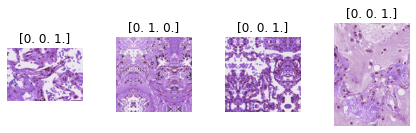

In [19]:
# check if the dataloader works
check_loader = LUAD(image_list=train_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

type(check_loader[1][1])

check_loader[1][1].shape

In [20]:
random_augs = [#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               #transforms.RandomGrayscale(p=0.1),            #Grayscale(num_output_channels=3),
               #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomVerticalFlip(p=0.5),
               transforms.RandomRotation(30),
               transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
               #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
               #transforms.RandomAdjustSharpness(sharpness_factor=2),
               ]

# creatin the train dataset
train_dataset = LUAD(train_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                                     transforms.RandomApply(random_augs, p=0.6),
                                                     ]))

# creating the test dataset
test_dataset = LUAD(test_list,
                    transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize((224, 224)),
                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),]
                                                    ))

In [21]:
batch_size = 64

In [22]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1,
                              )

# test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = 1,
                             )

In [23]:
len(train_dataloader)

176

# Creating the model

In [24]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)
#print(model(torch.randn(1, 3, 224, 224)))

In [25]:
torchsummary.summary(model_vit_base_patch16_224, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
         Identity-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 19

### Checking model properties

In [26]:
next(model_vit_base_patch16_224.parameters()).is_cuda

True

In [27]:
out = model_vit_base_patch16_224(torch.randn(10, 3, 224, 224).to(device))
out

tensor([[ 1.6537,  2.3655, -0.7828],
        [ 0.5574, -1.1976,  1.7610],
        [ 2.3751,  2.1004, -2.3137],
        [ 0.1811,  1.2167,  0.6338],
        [ 0.8022,  4.9353, -1.0542],
        [ 0.7129,  1.1825, -0.5487],
        [ 1.6364,  3.0238,  1.0781],
        [-1.0287,  1.6929,  1.7450],
        [ 1.9630,  1.7492,  0.2173],
        [-0.7111,  2.6300,  1.1635]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [28]:
y_p = nn.functional.softmax(out)
y_p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.3200, 0.6520, 0.0280],
        [0.2220, 0.0384, 0.7396],
        [0.5653, 0.4295, 0.0052],
        [0.1855, 0.5227, 0.2918],
        [0.0157, 0.9818, 0.0025],
        [0.3469, 0.5548, 0.0982],
        [0.1793, 0.7181, 0.1026],
        [0.0310, 0.4719, 0.4971],
        [0.5045, 0.4074, 0.0881],
        [0.0280, 0.7898, 0.1822]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [29]:
#y_p = y_p.round().detach().cpu().numpy()
y_p = y_p.round()
#y_p = nn.Threshold(0.25, 1.0)(y_p)
y_p

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [30]:
y_p.shape

torch.Size([10, 3])

In [31]:
'''
l = np.array([[0, 0, 1],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],]).astype('float32')
'''

l = np.array([[1., 1., 0.],
              [1., 0., 1.],
              [1., 1., 0.],
              [1., 1., 1.],
              [1., 1., 0.],
              [1., 1., 0.],
              [1., 1., 1.],
              [0., 1., 1.],
              [1., 1., 1.],
              [0., 1., 1.]]).astype('float32')

In [32]:
l = torch.tensor(l).to(device)

In [33]:
accuracy_score(l.cpu().detach().numpy(),
               y_p.cpu().detach().numpy())

0.0

In [34]:
loss = nn.CrossEntropyLoss()

In [35]:
loss(out, l)

tensor(2.5899, device='cuda:0', grad_fn=<DivBackward1>)

## Training and validation

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (x, y) in enumerate(data_loader):
    
    if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    y_pred = torch.softmax(model_out, dim=-1)
    
    # calculate loss
    loss = loss_fn(model_out, y)
    #print(loss) Printed the loss per batch per epoch
    #print(y.shape)
    #print(y_pred.shape)
    #print(type(y))
    #print(type(y_pred))
    train_loss += loss
    train_acc += eval_fn(np.argmax(y.cpu().detach().numpy().astype('float32'), axis=1),
                         np.argmax(y_pred.cpu().detach().numpy().astype('float32'), axis=1))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  #print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model(X)
      test_pred = torch.softmax(model_out, dim=-1)
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(model_out, y)
      test_acc += eval_fn(np.argmax(y.cpu().detach().numpy().astype('float32'), axis=1),
                          np.argmax(y_pred.cpu().detach().numpy().astype('float32'), axis=1))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [36]:
def epoch_step(model: torch.nn.Module,
               train_data_loader: torch.utils.data.DataLoader,
               test_data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):

#######################################################################################################################
#                                                                                                                     #
#                                                    Training                                                         #
#                                                                                                                     #
#######################################################################################################################
  
  train_loss, train_acc = 0, 0
  # put model in training mode
  model.train()
  loop = tqdm(enumerate(train_data_loader), total=len(train_data_loader), leave=False)
  for batch, (x, y) in loop:
    
    #if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    y_pred = nn.functional.softmax(model_out, dim=-1)
    
    # calculate loss and accuracy
    loss = loss_fn(model_out, y)
    acc  = eval_fn(y.cpu().argmax(axis=1),
                  y_pred.cpu().detach().numpy().argmax(axis=1))
    
    #print(loss) Printed the loss per batch per epoch
    #print(y.shape)
    #print(y_pred.shape)
    #print(type(y))
    #print(type(y_pred))
    
    # updating training loss and accuracy
    train_loss += loss
    train_acc += acc

    # back-prop
    loss.backward()

    # optimize
    opt.step()
  
  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(train_data_loader)
  train_acc /= len(train_data_loader)

  #print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

#######################################################################################################################
#                                                                                                                     #
#                                                    Validation                                                       #
#                                                                                                                     #
#######################################################################################################################

  test_loss, test_acc = 0, 0
  # put model in inferrence mode
  model.eval()
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in test_data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model(X)
      test_pred = nn.functional.softmax(model_out, dim=-1)
      
      # 2. Calculate loss and accuracy
      loss = loss_fn(model_out, y)
      acc  = eval_fn(y.cpu().argmax(axis=1),
                          test_pred.cpu().detach().numpy().argmax(axis=1))
      
      # updating training loss and accuracy
      test_loss += loss
      test_acc += acc
      
    # Adjust metrics and print out
    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    #print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    
    return test_loss, test_acc  

In [37]:
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth'

In [38]:
epochs = 50

In [39]:
valid_acc = -np.inf

for epoch in tqdm(range(epochs)):

  print(f'Epoch {epoch+1}/{epochs}')
  
  train_step(train_data_loader=train_dataloader,
             test_data_loader=test_dataloader,
             model=model_vit_base_patch16_224,
             loss_fn=nn.CrossEntropyLoss(),
             opt=Adam(model_vit_base_patch16_224.parameters(), lr=0.00001),
             eval_fn=accuracy_score
             )
  
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch16_224,
                                  loss_fn=nn.CrossEntropyLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}")


In [41]:
for epoch in tqdm(range(epochs)):

  print(f'Epoch {epoch+1}/{epochs}')
  
  ep_v_loss, ep_v_acc = epoch_step(train_data_loader=train_dataloader,
                                   test_data_loader=test_dataloader,
                                   model=model_vit_base_patch16_224,
                                   loss_fn=nn.CrossEntropyLoss(),
                                   opt=Adam(model_vit_base_patch16_224.parameters(), lr=0.0001),
                                   eval_fn=accuracy_score
                                   )
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}\n")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.81052 | Train accuracy: 0.65144 | Test loss: 1.00176 | Test accuracy: 0.75139

accuracy increased from -inf to 0.7513888888888889 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 2/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.40454 | Train accuracy: 0.84551 | Test loss: 0.52876 | Test accuracy: 0.81250

accuracy increased from 0.7513888888888889 to 0.8125 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 3/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.32705 | Train accuracy: 0.87863 | Test loss: 0.53981 | Test accuracy: 0.83472

accuracy increased from 0.8125 to 0.8347222222222223 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 4/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.25443 | Train accuracy: 0.90712 | Test loss: 0.27047 | Test accuracy: 0.90208

accuracy increased from 0.8347222222222223 to 0.9020833333333333 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 5/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.20856 | Train accuracy: 0.92435 | Test loss: 0.27308 | Test accuracy: 0.90312

accuracy increased from 0.9020833333333333 to 0.903125 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 6/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.18478 | Train accuracy: 0.93225 | Test loss: 0.14582 | Test accuracy: 0.95104

accuracy increased from 0.903125 to 0.9510416666666667 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 7/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.17102 | Train accuracy: 0.93590 | Test loss: 0.15772 | Test accuracy: 0.94757

accuracy did not increased from 0.9510416666666667
Epoch 8/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.15372 | Train accuracy: 0.94308 | Test loss: 0.20121 | Test accuracy: 0.94271

accuracy did not increased from 0.9510416666666667
Epoch 9/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.14614 | Train accuracy: 0.94557 | Test loss: 0.20816 | Test accuracy: 0.93472

accuracy did not increased from 0.9510416666666667
Epoch 10/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.13162 | Train accuracy: 0.95285 | Test loss: 0.15502 | Test accuracy: 0.95451

accuracy increased from 0.9510416666666667 to 0.9545138888888889 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth
Epoch 11/50


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.12790 | Train accuracy: 0.95418 | Test loss: 0.16767 | Test accuracy: 0.94549

accuracy did not increased from 0.9545138888888889
Epoch 12/50


  0%|          | 0/176 [00:00<?, ?it/s]

KeyboardInterrupt: ignored